In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow_gnn as tfgnn
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from functools import partial

from model import *
from utils import *

In [2]:
DATA_PATH = "../dbs/data2_no_self_interactions.csv"
FEATURES_PATH = "../dbs/id_features_data2.json"

negative_methods = ["common_neighbors", "same_degree_distribution", "most_close", "most_distant"]

k = 5

# define the search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -6, -2),
    'optimizer': hp.choice('optimizer', ['sgd', 'adam', 'nadam']),
    'activation': hp.choice('activation', ['relu', 'sigmoid', 'tanh', 'leaky_relu'])
}

results = {}

In [3]:
# make and early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
# save each kfold of each method
methods_folds = {}
methods_input_graph = {}

for method in negative_methods:
    # Create a graph of protein interactions for each method
    graphToTensor = GraphToTensor(DATA_PATH, FEATURES_PATH, method)
    graph_tensor = graphToTensor.graph_tensor

    dataset = create_dataset(graph_tensor, edge_batch_merge)

    graph_spec = dataset.element_spec[0]
    input_graph = tf.keras.layers.Input(type_spec=graph_spec)

    # Generate k-folds for each method
    kfolds = graphToTensor.generate_graph_tensors_for_k_folds(k_folds=k)
    
    # save each kfold of each method
    methods_folds[method] = kfolds
    methods_input_graph[method] = input_graph

In [6]:
def objective(params, kfolds, input_graph):

    # unpack the parameters
    learning_rate = params['learning_rate']
    optimizer_type = params['optimizer']
    activation = params['activation']

    # for storing y and yhat across all folds
    y_folds = []
    yhat_folds = []

    for i, (train_graph, test_graph) in enumerate(kfolds):

        # Create datasets for this fold
        train_dataset = create_dataset(train_graph, edge_batch_merge)
        test_dataset = create_dataset(test_graph, edge_batch_merge)

        model = create_model(input_graph, graph_updates=3, activation=activation)

        # choose the optimizer
        if optimizer_type == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer_type == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_type == 'nadam':
            optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

        # Compile the model
        model.compile(
            optimizer,
            loss='binary_crossentropy',
            metrics=['Accuracy']
        )
            
        # Fit the model for this fold
        model.fit(
            train_dataset.repeat(),
            epochs=1000,
            steps_per_epoch=10,
            validation_data=test_dataset.repeat(),
            validation_steps=10,
            callbacks=[early_stopping],
            verbose=0
        )

        # store y and yhat for this fold
        yhat = model.predict(test_dataset, verbose=0)
        y = test_dataset.map(lambda graph, labels: labels).unbatch()
        y = np.array(list(y.as_numpy_iterator()))
        yhat = np.array(list(yhat))

        y_folds.append(y)
        yhat_folds.append(yhat)

        # Delete the model to free up memory
        del model

    # get the predictions for all folds
    y = np.concatenate(y_folds)
    yhat = np.concatenate(yhat_folds)

    accuracy = accuracy_score(y, yhat.round())

    # use accuracy as the objective to maximize
    return {'loss': -accuracy, 'status': STATUS_OK}

In [7]:
best_params_per_method = {}

for method in negative_methods:
    print(f'Optimizing for {method}...')
    # create a partial function with the negative method as a parameter
    objective_partial = partial(objective, kfolds=methods_folds[method], input_graph=methods_input_graph[method])

    # run the hyperparameter optimization
    trials = Trials()
    best = fmin(
        fn=objective_partial,
        space=space,
        algo=tpe.suggest,
        max_evals=10,
        trials=trials
    )

    # store the best parameters for this method
    best_params_per_method[method] = best

    # store the results
    results[method] = trials

Optimizing for common_neighbors...
100%|██████████| 10/10 [15:02<00:00, 90.25s/trial, best loss: -0.9451103898190699]
Optimizing for same_degree_distribution...
100%|██████████| 10/10 [21:10<00:00, 127.08s/trial, best loss: -0.9223575537487547]
Optimizing for most_close...
100%|██████████| 10/10 [15:21<00:00, 92.15s/trial, best loss: -0.8312980043063277]
Optimizing for most_distant...
100%|██████████| 10/10 [17:16<00:00, 103.63s/trial, best loss: -0.9686023716939294]


In [8]:
for method, best_params in best_params_per_method.items():
    best_params['learning_rate'] = np.exp(best_params['learning_rate'])
    best_params['optimizer'] = ['sgd', 'adam', 'nadam'][best_params['optimizer']]
    best_params['activation'] = ['relu', 'sigmoid', 'tanh', 'leaky_relu'][best_params['activation']]
    print(f"For {method}, the best parameters are: {best_params}")

For common_neighbors, the best parameters are: {'activation': 'relu', 'learning_rate': 1.006300830879779, 'optimizer': 'nadam'}
For same_degree_distribution, the best parameters are: {'activation': 'relu', 'learning_rate': 1.018635661651768, 'optimizer': 'nadam'}
For most_close, the best parameters are: {'activation': 'leaky_relu', 'learning_rate': 1.0499203079028083, 'optimizer': 'nadam'}
For most_distant, the best parameters are: {'activation': 'relu', 'learning_rate': 1.0095934883958342, 'optimizer': 'nadam'}


In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, confusion_matrix, recall_score

In [10]:
# train the best model for each method
for method, best_params in best_params_per_method.items():
    print(f'Training the best model for {method}...')

    # unpack the parameters
    learning_rate = best_params['learning_rate']
    optimizer_type = best_params['optimizer']
    activation = best_params['activation']

    # for storing y and yhat across all folds
    y_folds = []
    yhat_folds = []
    
    for i, (train_graph, test_graph) in enumerate(methods_folds[method]):
        # Create datasets for this fold
        train_dataset = create_dataset(train_graph, edge_batch_merge)
        test_dataset = create_dataset(test_graph, edge_batch_merge)

        model = create_model(methods_input_graph[method], graph_updates=3, activation=activation)

        # choose the optimizer
        if optimizer_type == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer_type == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_type == 'nadam':
            optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

        # Compile the model
        model.compile(
            optimizer,
            loss='binary_crossentropy',
            metrics=['Accuracy']
        )
            
        # Fit the model for this fold
        model.fit(
            train_dataset.repeat(),
            epochs=1000,
            steps_per_epoch=10,
            validation_data=test_dataset.repeat(),
            validation_steps=10,
            callbacks=[early_stopping],
            verbose=0
        )

        # store y and yhat for this fold
        yhat = model.predict(test_dataset, verbose=0)
        y = test_dataset.map(lambda graph, labels: labels).unbatch()
        y = np.array(list(y.as_numpy_iterator()))
        yhat = np.array(list(yhat))

        y_folds.append(y)
        yhat_folds.append(yhat)

        # Delete the model to free up memory
        del model
        
    # get the predictions for all folds
    y = np.concatenate(y_folds)
    yhat = np.concatenate(yhat_folds)
    
    # get confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, yhat.round()).ravel()
    
    # get averge confusion matrix
    tn /= len(methods_folds[method])
    fp /= len(methods_folds[method])
    fn /= len(methods_folds[method])
    tp /= len(methods_folds[method])
    
    # store the results
    results[method] = {
        'ROC AUC': roc_auc_score(y, yhat),
        'Precision': average_precision_score(y, yhat),
        'F1': f1_score(y, yhat.round()),
        'Accuracy': accuracy_score(y, yhat.round()),
        'confusion_matrix': (tn, fp, fn, tp),
        'recall': recall_score(y, yhat.round())
    }

Training the best model for common_neighbors...
Training the best model for same_degree_distribution...
Training the best model for most_close...
Training the best model for most_distant...


In [11]:
from pprint import pprint

# print the results ROC AUC Average Precision F1 Accuracy, don't print the ROC AUC Curve and the confusion matrix 
for method, result in results.items():
    print(f'{method}:')
    pprint({k: v for k, v in result.items() if k != 'ROC AUC Curve' and k != 'confusion_matrix'})
    print()


common_neighbors:
{'Accuracy': 0.9924639264710609,
 'F1': 0.9924934778085436,
 'Precision': 0.9992505080898326,
 'ROC AUC': 0.9987512429737591,
 'recall': 0.9966569160050146}

same_degree_distribution:
{'Accuracy': 0.908153099591863,
 'F1': 0.9134621207533459,
 'Precision': 0.9701342737167367,
 'ROC AUC': 0.9685542842558637,
 'recall': 0.969751518853065}

most_close:
{'Accuracy': 0.7820805347559212,
 'F1': 0.7890824261275271,
 'Precision': 0.8730265890428152,
 'ROC AUC': 0.8742782255060939,
 'recall': 0.815487479507538}

most_distant:
{'Accuracy': 0.9593148439759617,
 'F1': 0.960773377951292,
 'Precision': 0.9794766221712432,
 'ROC AUC': 0.984042799117651,
 'recall': 0.9967533511202545}



In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

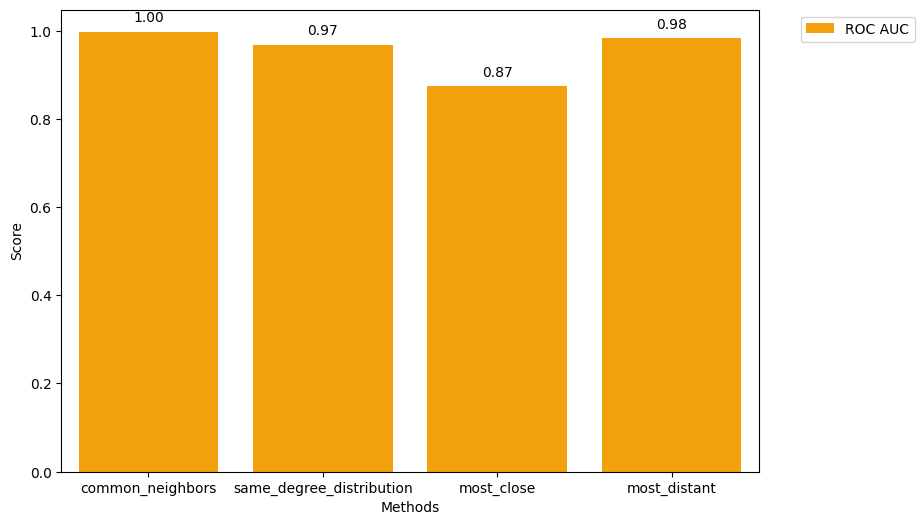

In [13]:
# plot ROC bars for each
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'ROC AUC', result['ROC AUC']])
        
# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(9,6))

bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette=['orange'], saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')
    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

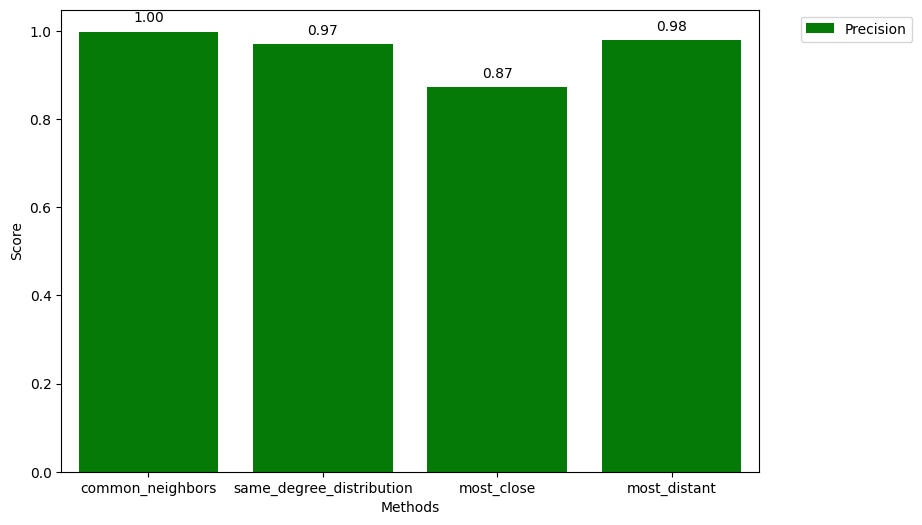

In [14]:
# plot precision bars for each method
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'Precision', result['Precision']])
        
        
# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(9,6))

bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette=['green'], saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')
    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

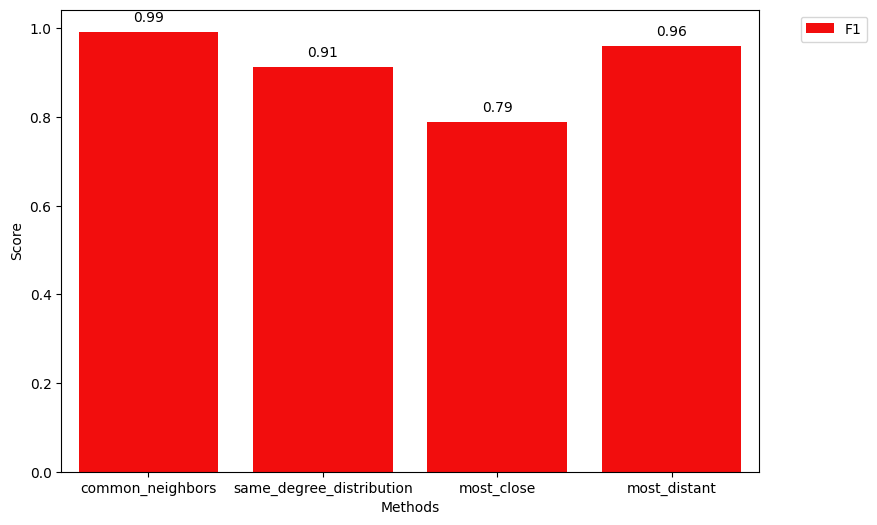

In [15]:
# plot F1 bars for each method
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'F1', result['F1']])
        
        
# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(9,6))

bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette=['red'], saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')
    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

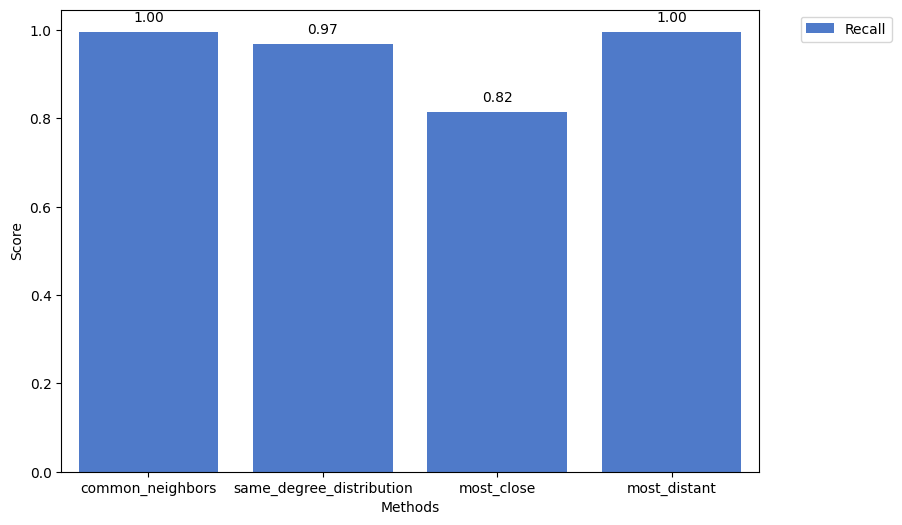

In [16]:
# plot the results Recall
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'Recall', result['recall']])
        
# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(9,6))
bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette='muted', saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')
    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

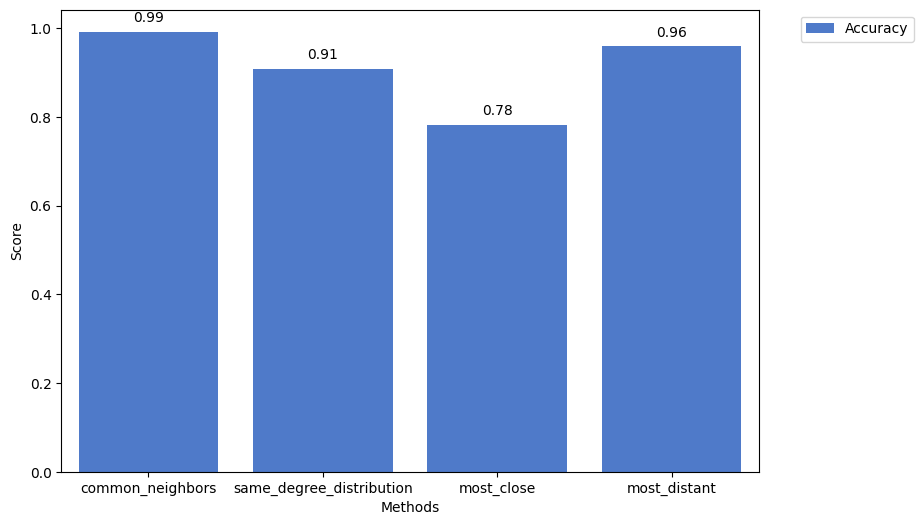

In [17]:
# plot Accuracy
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'Accuracy', result['Accuracy']])
        
# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(9,6))
bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette='muted', saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')
    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

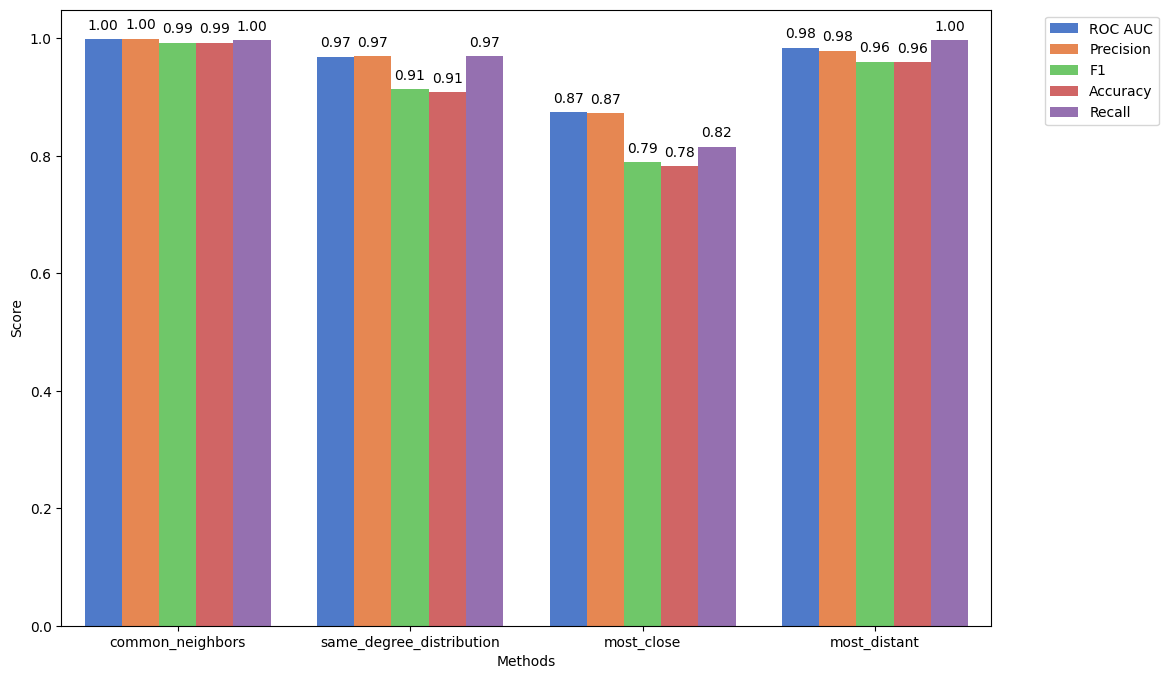

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for DataFrame
data = []
for method, result in results.items():
    if method in negative_methods:
        data.append([method, 'ROC AUC', result['ROC AUC']])
        data.append([method, 'Precision', result['Precision']])
        data.append([method, 'F1', result['F1']])
        data.append([method, 'Accuracy', result['Accuracy']])
        data.append([method, 'Recall', result['recall']])

# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(12,8))
bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette='muted', saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

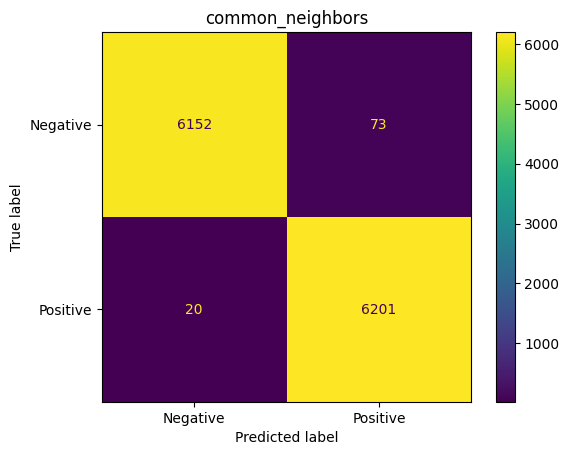

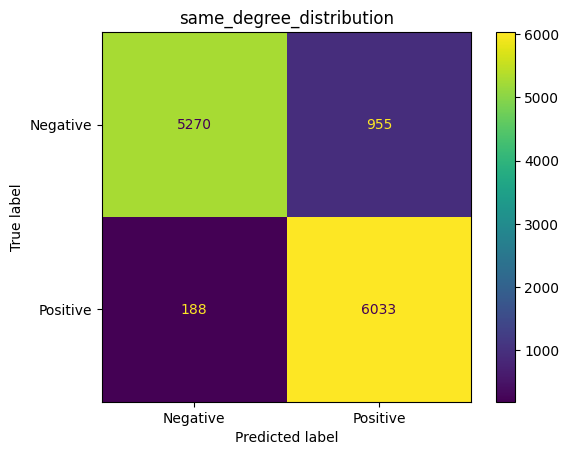

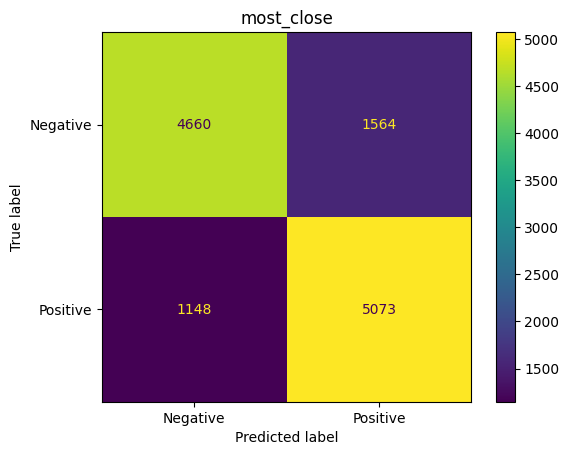

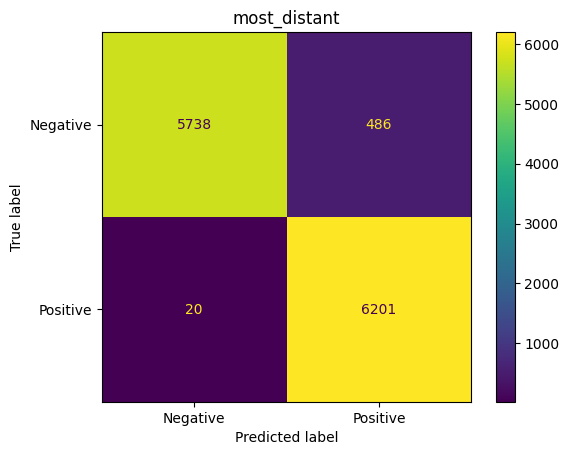

: 

In [19]:
# plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method, result in results.items():
    if method in negative_methods:
        cm = np.array([
            [int(result['confusion_matrix'][0]), int(result['confusion_matrix'][1])],
            [int(result['confusion_matrix'][2]), int(result['confusion_matrix'][3])]
        ])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot()
        plt.title(method)
        plt.show()